In [52]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn import linear_model

In [53]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json", "r") as f:
    alldata = json.loads(f.read())

# Train

In [3]:
alldata.keys()

dict_keys(['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST'])

In [4]:
isone = alldata["ISONE CA"]

In [13]:
isone.keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt', 'SYSLoad', 'RegCP'])

In [56]:
slc = 361 * 24
cap = 365 * 24
demand = np.array(isone["DEMAND"][-(slc + cap):-cap], dtype=np.float64)
hour = np.array(isone["Hour"][-(slc + cap):-cap], dtype=np.uint8)
# 1/5/2015 was Sunday, so starts with 0
days_of_week = [0, 1, 2, 3, 4, 5, 6]
week = np.array(list(days_of_week[(i // 24) % 7] for i in range(slc)), dtype=np.uint8)
month = np.array(list(map(lambda x: int(x[5:7]), isone["Date"][-(slc + cap):-cap])), dtype=np.uint8)
trend = np.arange(slc)

In [57]:
raw_temp = np.array(isone["DryBulb"])
temps= []
for year in range(10):
    for shift in range(9):
        offset = int(year * 365.24 + shift) * 24
        temps.append(raw_temp[offset: offset + slc])

In [58]:
regs = []
for temp in temps:
    weekhour = week * hour
    temp2 = temp ** 2
    temp3 = temp ** 3
    tempmonth = temp * month
    temp2month = temp2 * month
    temp3month = temp3 * month
    temphour = temp * hour
    temp2hour = temp2 * hour
    temp3hour = temp3 * hour

    regs.append(linear_model.LinearRegression())

    variables = [trend, month, week, hour, weekhour, temp, temp2, temp3, tempmonth, temp2month, temp3month,
                 temphour, temp2hour, temp3hour]
    variables = list(map(list, zip(*variables)))  # transpose
    regs[-1].fit(variables, demand)

<IPython.core.display.Javascript object>


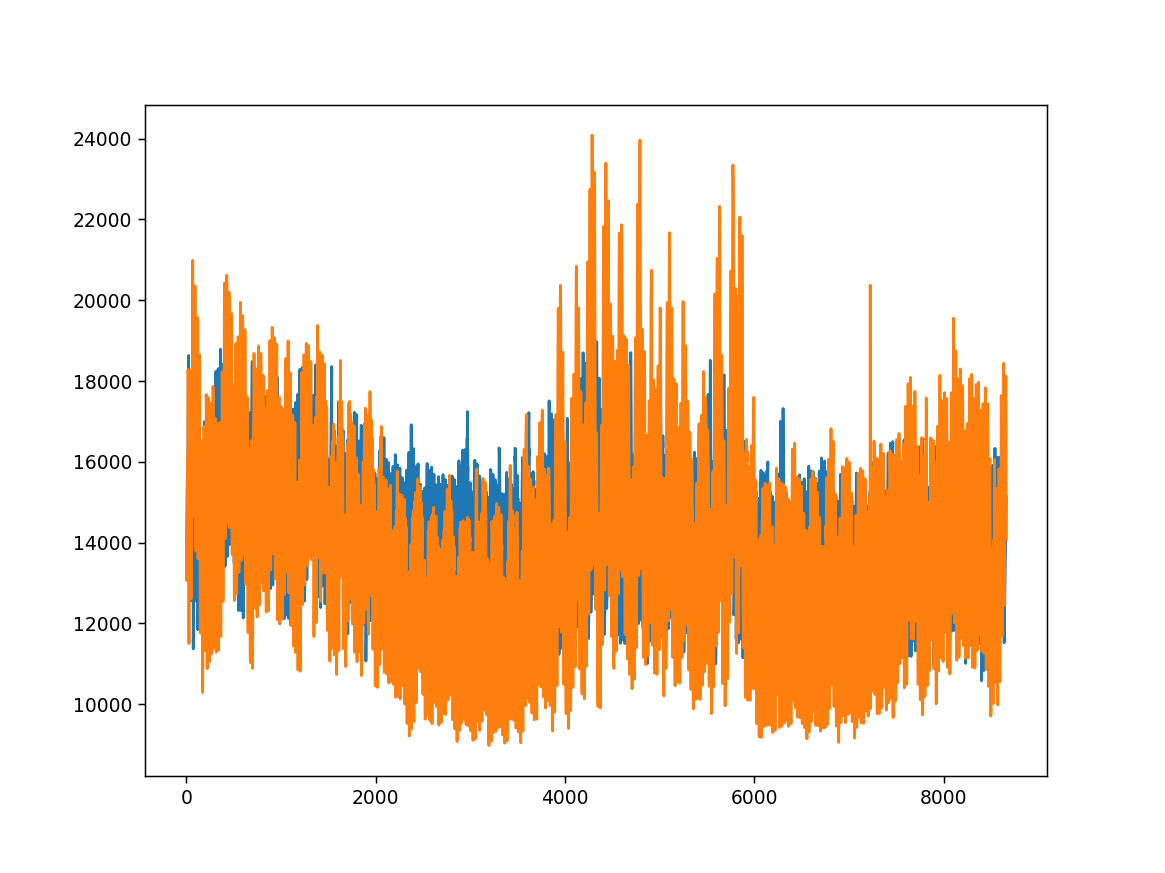

In [59]:
fit = regs[3].predict(variables)
plt.figure()
plt.plot(fit)
plt.plot(demand)
plt.show()

# Test

In [60]:
slc = 31 * 24
cap = (365 - 31) * 24
test_demand = np.array(isone["DEMAND"][-(slc + cap):-cap], dtype=np.float64)
hour = np.array(isone["Hour"][-(slc + cap):-cap], dtype=np.uint8)
# 1/5/2015 was Sunday, so starts with 0
days_of_week = [0, 1, 2, 3, 4, 5, 6]
week = np.array(list(days_of_week[(i // 24) % 7] for i in range(slc)), dtype=np.uint8)
month = np.array(list(map(lambda x: int(x[5:7]), isone["Date"][-(slc + cap):-cap])), dtype=np.uint8)
trend = np.arange(slc)

In [61]:
temp = np.array(isone["DryBulb"][-(slc + cap):-cap])

In [62]:
weekhour = week * hour
temp2 = temp ** 2
temp3 = temp ** 3
tempmonth = temp * month
temp2month = temp2 * month
temp3month = temp3 * month
temphour = temp * hour
temp2hour = temp2 * hour
temp3hour = temp3 * hour
test_variables = [trend, month, week, hour, weekhour, temp, temp2, temp3, tempmonth, temp2month, temp3month,
             temphour, temp2hour, temp3hour]
test_variables = list(map(list, zip(*test_variables)))  # transpose

In [63]:
preds = []
for reg in regs:
    preds.append(reg.predict(test_variables))

In [65]:
preds = np.array(preds)

<IPython.core.display.Javascript object>


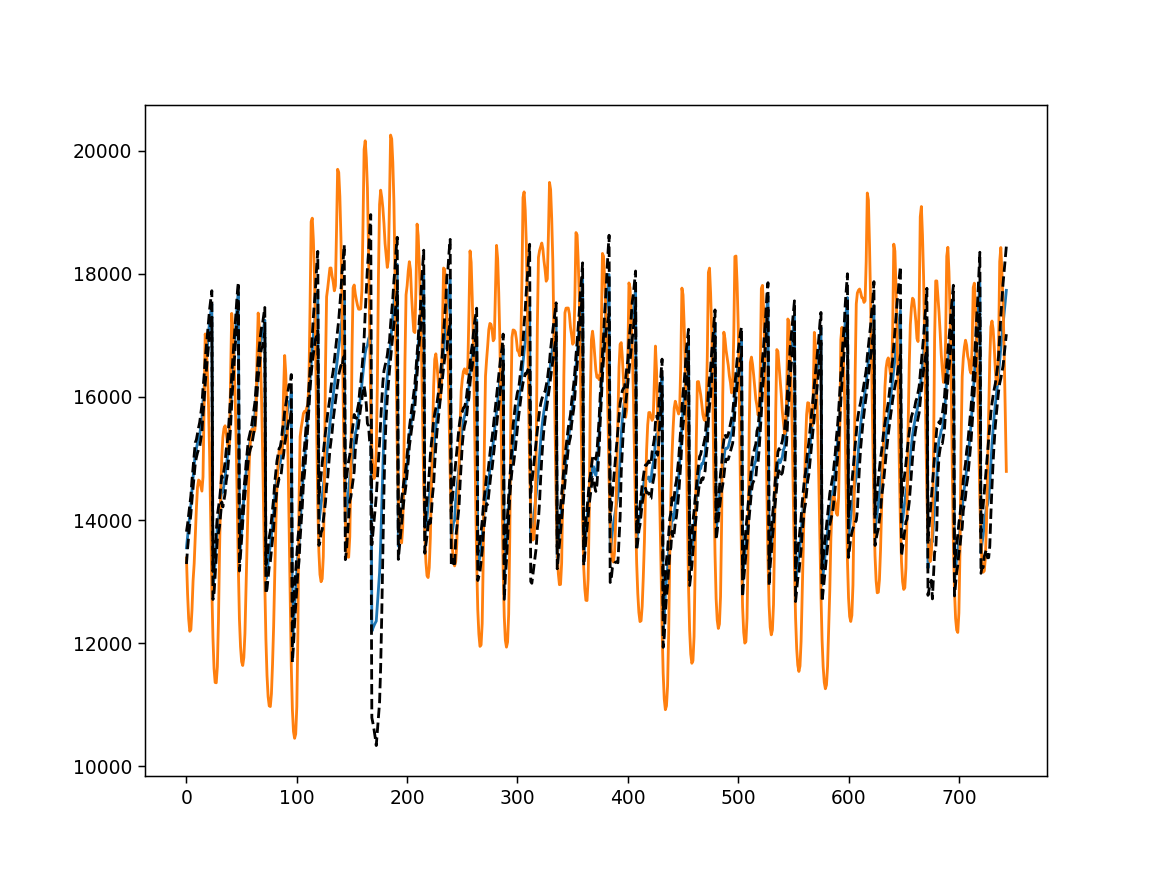

In [86]:
pred = np.mean(preds, axis=0)
std = np.std(preds, axis=0)
plt.figure()
plt.plot(pred)
plt.plot(test_demand)
plt.plot(std + pred, linestyle="--", color="black")
plt.plot(pred - std, linestyle="--", color="black")
plt.show()

In [97]:
def pinball_loss(data, quant_preds, quantiles):
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / len(data)

In [98]:
quant_preds = []
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for t in range(preds.shape[1]):
    sorted_preds = np.sort(preds[:, t])
    quant_pred = []
    for q in quantiles:
        idx = int(q * preds.shape[0] + 0.5)
        quant_pred.append(sorted_preds[idx])
    quant_preds.append(quant_pred)

In [99]:
print(quant_preds[100])

[12884.81130862739, 12959.769936857598, 13006.285667144835, 13062.44265208415, 13157.015504451145, 13232.724140684484, 13301.675435907155, 13403.927514094252, 13532.183923214923]


In [100]:
pinball_loss(test_demand, quant_preds, quantiles)

7546.179953291188